In [156]:
import pandas as pd
import numpy as np
import gensim
import nltk
import datetime
import time
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel,Phrases
from gensim.models.phrases import Phraser
from gensim.models import word2vec
from nltk import word_tokenize
from nltk.tag import StanfordNERTagger 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [130]:
movies1_df = pd.read_json('data/eng_1_430.json')
movies2_df = pd.read_json('data/eng_431_601.json')
movies = movies1_df.append(movies2_df)
print(movies.shape)
movies.head()

(56005, 2)


,summary,title
0,nown as 1 Life On The Limit is a 2013 document...,1 (2013 film)
1,While on the phone with his girlfriend Jill w...,+1 (film)
10,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film)
100,o Christmas is a Ghanaian drama movie about Re...,6 Hours To Christmas
1000,r is a 1995 American romantic drama television...,The Affair (1995 film)


In [135]:
movies.shape

(56005, 2)

In [187]:
import random
sample = random.sample(list(movies['summary']),25000)
sample1 = sample[:12501]
sample2 = sample[12501:]
sample3 = list(movies['summary'])[30000:45001]
sample4 = list(movies['summary'])[45000:]

In [264]:
df_movies = movies.loc[movies['summary'].isin(sample1)]

In [188]:
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       '/Users/alexanderbailey/Documents/stanford-ner-2018-10-16/stanford-ner.jar')
#names = tag_words(sample1, st)

In [218]:
list(names)[:10]
names.union(set(map(lambda x: x.lower(),names)))

73851

In [192]:
import pickle
with open('data/names_list1.pkl', 'wb') as f:
    pickle.dump(names, f)

In [219]:
#st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
#                        '/Users/alexanderbailey/Documents/stanford-ner-2018-10-16/stanford-ner.jar')
#names = tag_words(list(movies['summary']))
names = names.union(set(map(lambda x: x.lower(),names)))
stop_words = stopwords.words('english')
stop_words += ['film', 'directed', 'film_directed', 'series',
               'story', 'american', 'starring', 'films', 'direct',
               'produced', 'stars', 'released']
stop_words = set(stop_words).union(names)


In [197]:
def get_tag(idx,doc,st):
    if idx % 1000:
        print(idx)
        return st.tag(doc.split())

def tag_words(texts, st):
    tags = [get_tag(idx,doc,st) for idx,doc in enumerate(texts)]
    names = [set([word for word,tag in doc if tag != 'O']) for doc in tags]
    return set.union(*names)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = Phrases(words, min_count = bi_min)
    bigram_mod = Phraser(bigram)
    return bigram_mod

def refactor_corpus(bigram):
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=15, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word

def get_corpus(df):
    #words = list(df['summary'])
    words = remove_stopwords(df)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[plot] for plot in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=15, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [220]:
now = datetime.datetime.now()
m_corpus, m_id2word, bigram = get_corpus(sample1)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

Time:  0:00:11.615815


In [137]:
doc_sample = movies[movies['title'] == "Breakfast at Tiffany's (film)"].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['', 'Early', 'one', 'morning', 'a', 'taxi', 'pulls', 'up', 'in', 'front', 'of', 'Tiffany', '', 'Co', '', 'and', 'from', 'it', 'emerges', 'elegantly', 'dressed', 'Holly', 'Golightly', 'carrying', 'a', 'paper', 'bag', 'containing', 'her', 'breakfast', 'After', 'looking', 'into', 'its', 'windows', 'she', 'strolls', 'to', 'her', 'apartment', 'and', 'has', 'to', 'fend', 'off', 'her', 'date', 'from', 'the', 'night', 'before', 'Once', 'inside', 'Holly', 'cannot', 'find', 'her', 'keys', 'so', 'she', 'buzzes', 'her', 'landlord', 'Mr', 'Yunioshi', 'to', 'let', 'her', 'in', 'Later', 'she', 'is', 'awakened', 'by', 'new', 'neighbor', 'Paul', 'Varjak', 'who', 'rings', 'her', 'doorbell', 'to', 'get', 'into', 'the', 'building', 'The', 'pair', 'chat', 'as', 'she', 'dresses', 'to', 'leave', 'for', 'her', 'weekly', 'visit', 'to', 'Sally', 'Tomato', 'a', 'mobster', 'incarcerated', 'at', 'Sing', 'Sing', 'Tomatos', 'lawyer', 'pays', 'her', '100', 'a', 'week', 'to', 'deliver', 'the', 'we

In [39]:
processed_docs = movies['summary'].map(preprocess)


In [40]:
dictionary  = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    count += 1
    if count > 10:
        break

In [41]:
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

In [42]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [43]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


In [148]:
hdp_model = gensim.models.HdpModel(corpus=m_corpus, id2word=m_id2word, random_state=56)


In [153]:
for idx, topic in hdp_model.print_topics(num_topics=-1, num_words=5):
    print('Topic : {} Word: {}'.format(idx, topic))

In [221]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=8,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(num_topics=-1):
    print('Topic : {} Word: {}'.format(idx, topic))

Topic : 0 Word: 0.014*"students" + 0.009*"begins" + 0.009*"must" + 0.008*"become" + 0.008*"becomes" + 0.006*"patients" + 0.005*"patient" + 0.005*"creatures" + 0.005*"trial" + 0.004*"schools"
Topic : 1 Word: 0.011*"tries" + 0.010*"says" + 0.010*"away" + 0.008*"begins" + 0.008*"leave" + 0.007*"apartment" + 0.006*"runs" + 0.006*"starts" + 0.005*"reveals" + 0.005*"attempts"
Topic : 2 Word: 0.024*"novel" + 0.016*"character" + 0.015*"romantic" + 0.014*"thriller" + 0.014*"concerns" + 0.011*"name" + 0.011*"upcoming" + 0.011*"rebels" + 0.010*"writer" + 0.010*"tail"
Topic : 3 Word: 0.009*"becomes" + 0.009*"decides" + 0.008*"work" + 0.008*"relationship" + 0.008*"meets" + 0.006*"become" + 0.006*"parents" + 0.005*"would" + 0.005*"agrees" + 0.005*"married"
Topic : 4 Word: 0.016*"named" + 0.009*"work" + 0.007*"parents" + 0.007*"grandmother" + 0.006*"uses" + 0.005*"sell" + 0.005*"visit" + 0.005*"plantation" + 0.005*"pet" + 0.005*"painting"
Topic : 5 Word: 0.025*"president" + 0.019*"known" + 0.013*"rel

0: Medical/Academic
1: 
2: Dramatic Thriller
3: Romance
4: Family
5: Political Trhiller
6: Acting/Musicians
7: Violence/War

In [223]:
coherence_values = []
model_list = []
for num_topics in range(2,100,6):
    model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=num_topics,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, 
                                    texts=bigram,
                                    dictionary=m_id2word,
                                   coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

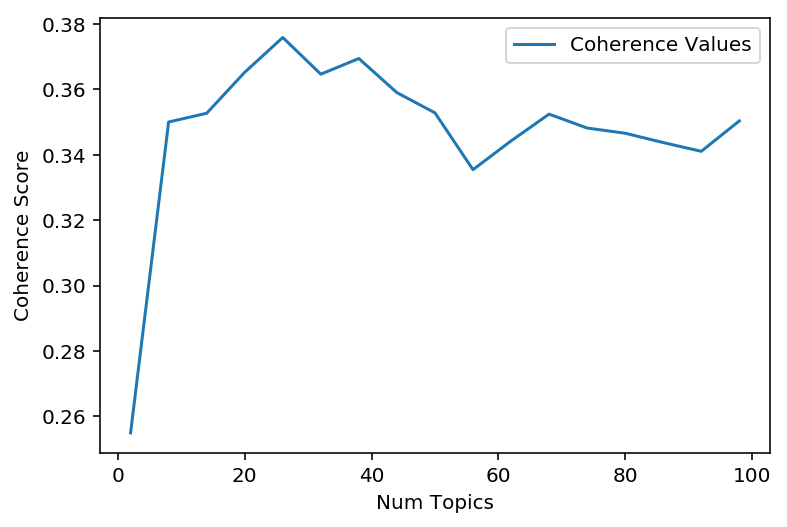

In [224]:

X = np.arange(2,100,6)

fig, ax = plt.subplots()
ax.plot(X, coherence_values, label="Coherence Values")
ax.set_xlabel('Num Topics')
ax.set_ylabel('Coherence Score')
plt.legend()
plt.show()

In [240]:
for topic in range(20):
    print('Topic : ' + str(topic) + ' Words: ')
    for word in range(10):
        print(model_list[3].show_topic(topic)[word][0] + ", ", end="")
    print('')
#model_list[4].show_topic(3)[2][0]

Topic : 0 Words: 
player, players, playing, teams, present, spell, games, goal, subjects, explores, 
Topic : 1 Words: 
parents, silent, couple, concerns, yearold, illness, gifts, middleaged, abortion, paying, 
Topic : 2 Words: 
murdered, named, begins, victims, killing, search, alive, becomes, discover, disappearance, 
Topic : 3 Words: 
decides, gives, agrees, leave, marry, give, meets, business, married, tries, 
Topic : 4 Words: 
relationship, begins, becomes, apartment, work, meets, move, parents, become, boyfriend, 
Topic : 5 Words: 
killed, evidence, robbery, killing, arrest, trial, jail, involved, criminals, murdered, 
Topic : 6 Words: 
killed, led, diary, torture, vengeance, corruption, completed, scheduled, serum, drown, 
Topic : 7 Words: 
would, final, dies, becomes, begins, attempt, sent, died, become, must, 
Topic : 8 Words: 
novel, role, release, character, name, premiere, nominated, thriller, writer, received, 
Topic : 9 Words: 
work, becomes, named, sell, discovers, plans,

Topic 0: Sports/Games
player, players, playing, teams, present, spell, games, goal, subjects, explores

Topic 1: Family Drama
parents, silent, couple, concerns, yearold, illness, gifts, middleaged, abortion, paying

Topic 2: Crime/Murder
murdered, named, begins, victims, killing, search, alive, becomes, discover, disappearance

Topic 3: Agreement,Contract
decides, gives, agrees, leave, marry, give, meets, business, married, tries

Topic 4: Early Romance
relationship, begins, becomes, apartment, work, meets, move, parents, become, boyfriend

Topic 5: Crime/Cops/Courts
killed, evidence, robbery, killing, arrest, trial, jail, involved, criminals, murdered

Topic 6: Cerebral Crime/Thriller
killed, led, diary, torture, vengeance, corruption, completed, scheduled, serum, drown

Topic 7: Existential
would, final, dies, becomes, begins, attempt, sent, died, become, must

Topic 8: Based on Book/About a Book
novel, role, release, character, name, premiere, nominated, thriller, writer, received

Topic 9: Heist
work, becomes, named, sell, discovers, plans, turns, casino, gambling, plan

Topic 10: Theater/Performance
including, concert, interviews, featuring, premiered, members, september, well, release, version

Topic 11: Western/Melodrama
played, wish, cattle, roles, drivers, wishes, notorious, comedydrama, character, affair

Topic 12: Comedy/Performance
comic, script, internet, online, used, document, documents, tape, performed, exwife

Topic 13: War/Politics
president, mine, chief, spy, plot, program, americans, work, enemy, put

Topic 14: Highschool/Students
students, known, romantic, distributed, schools, pride, shown, inspired, adapted, considered

Topic 15: Boats,Thriller
killed, ship, orders, killing, captured, reveals, attempts, uses, manages, attacked

Topic 16: Seeking Freedom
th, plantation, villagers, slave, curse, tent, adaptation, starred, genie, called

Topic 17: On the Run
away, tries, says, leave, runs, begins, reveals, explains, starts, turns

Topic 18: Production
pub, robbers, sets_designed, promote, alternative, laser, course, published, could, often

Topic 19: Planes
plane, pilot, flight, passengers, fighter, depression, passenger, engine, commercial, pilots

In [226]:
for m, cv in zip(X, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2549
Num Topics = 8  has Coherence Value of 0.35
Num Topics = 14  has Coherence Value of 0.3527
Num Topics = 20  has Coherence Value of 0.3653
Num Topics = 26  has Coherence Value of 0.3759
Num Topics = 32  has Coherence Value of 0.3647
Num Topics = 38  has Coherence Value of 0.3695
Num Topics = 44  has Coherence Value of 0.359
Num Topics = 50  has Coherence Value of 0.3529
Num Topics = 56  has Coherence Value of 0.3355
Num Topics = 62  has Coherence Value of 0.3443
Num Topics = 68  has Coherence Value of 0.3525
Num Topics = 74  has Coherence Value of 0.3482
Num Topics = 80  has Coherence Value of 0.3466
Num Topics = 86  has Coherence Value of 0.3438
Num Topics = 92  has Coherence Value of 0.3411
Num Topics = 98  has Coherence Value of 0.3504


In [241]:
topic_vecs = []
for i in range(len(sample1)):
    top_topics = model_list[3].get_document_topics(m_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vecs.append(topic_vec)

In [256]:
topic_vecs[0]

[0.24095818,
 0.00043120372,
 0.00043120372,
 0.046507515,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.00043120372,
 0.023426555,
 0.00043120372,
 0.6104636,
 0.00043120372,
 0.0493013,
 0.02330595,
 0.00043120372]

In [244]:
topic = topic_vecs[0].index(max(topic_vecs[0]))

### Extracting Target

In [258]:
topic_names = ['Sports/Games','Family Drama','Crime/Mystery','Contracts','Beginning Romance',
               'Crime/Courtroom Drama','Cerebral Thriller','Existential','Books/Based on Book','Heist',
               'Performance/Theater','Western/Melodrama','Performance/Comedy','War/Politics','Highschool/Students',
               'Thriller involving Boats','Seeking Freedom', 'On the Run', 'Production', 'Planes']
topic_names[topic]

'Thriller involving Boats'

In [259]:
topic_nums = [vec.index(max(vec)) for vec in topic_vecs]
topics = np.array([topic_names[topic] for topic in topic_nums])
topics[:10]

array(['Thriller involving Boats', 'Heist', 'Performance/Comedy',
       'Western/Melodrama', 'On the Run', 'Heist', 'On the Run',
       'Performance/Theater', 'Beginning Romance', 'Heist'], dtype='<U24')

In [268]:
df_movies.loc[:,'label'] = topics
df_movies.head()
df_movies.to_json('labeled_movies.json')

,summary,title,label
1,While on the phone with his girlfriend Jill w...,+1 (film),Thriller involving Boats
10,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film),Heist
10002,Cher Horowitz lives in a Beverly Hills mansio...,Clueless (film),Performance/Comedy
10009,In 1999 Ken Carter takes over the head coachi...,Coach Carter,Western/Melodrama
10011,Jim Brandon Robert Conrad a former player for...,Coach of the Year (film),On the Run


### Word Embedding

In [272]:
text = df_movies['summary']
total_vocabulary = set(word for summary in text for word in summary)

In [115]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [116]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [275]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [276]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]
scores = [(name, cross_val_score(model, text, topic_nums, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default va

In [277]:
scores

[('Random Forest', 0.15126566156296117),
 ('Support Vector Machine', 0.177265874316186),
 ('Logistic Regression', 0.1775054520573457)]